<a href="https://colab.research.google.com/github/AryaKoureshi/Emotion-Detection/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ananthu017/emotion-detection-fer
! unzip emotion-detection-fer.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [9]:
# imports
import cv2
import glob
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import save_model, Model, model_from_json, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16


In [3]:
# parameters
numClasses = 6
height = 48
weight = 48
batchSize = 64

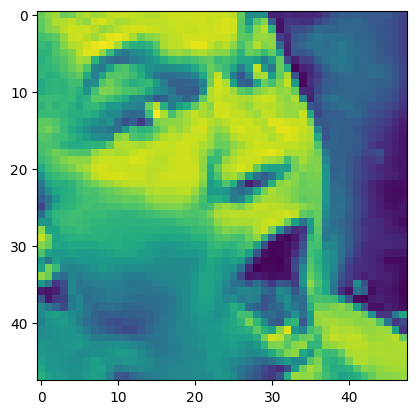

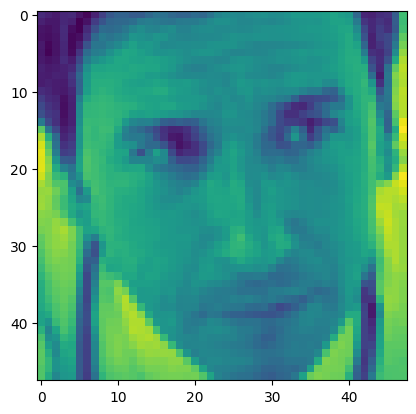

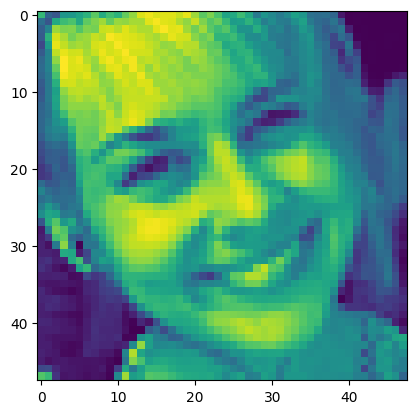

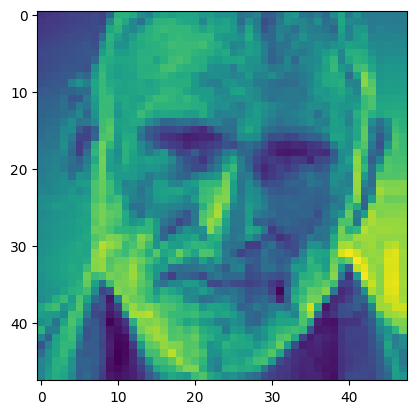

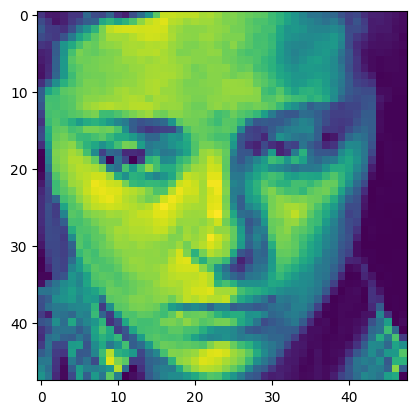

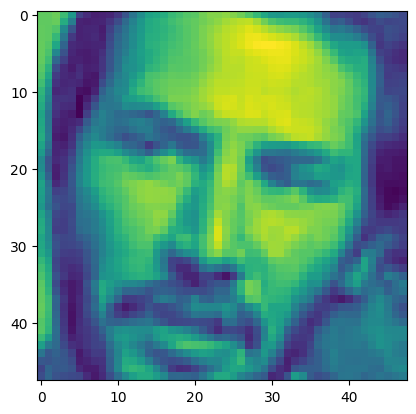

In [4]:
# loading data
x_train = []
y_train = []
x_test = []
y_test = []

cnt = 0
for temp in ["angry", "fearful", "happy", "neutral", "sad", "surprised"]:
    if temp == "angry":
        label = 0
    elif temp == "fearful":
        label = 1
    elif temp == "happy":
        label = 2
    elif temp == "neutral":
        label = 3
    elif temp == "sad":
        label = 4
    elif temp == "surprised":
        label = 5
    #elif temp == "disgusted":
        #label = 6

    path = "/content/train/{}/".format(temp)
    images = glob.glob(path + "*.png")
    images.sort()
    for x in images:
       image = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
       image = image / 255
       image = trans.resize(image,(height,weight))
       y_train.append(label)
       x_train.append(image)

    path = "/content/test/{}/".format(temp)
    images = glob.glob(path + "*.png")
    images.sort()
    for x in images:
       image = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
       image = image / 255
       image = trans.resize(image,(height,weight))
       y_test.append(label)
       x_test.append(image)
    if cnt <= numClasses:
      plt.figure()
      plt.imshow(image)
    cnt += 1

In [5]:
# preparing data
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.reshape(x_train, (len(x_train), height, weight, 1))
x_test = np.reshape(x_test, (len(x_test), height, weight, 1))
y_train= to_categorical(y_train, num_classes=numClasses)
y_test = to_categorical(y_test, num_classes=numClasses)

In [6]:
def model1(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

model = model1((height,weight,1), numClasses)
history = model.fit(x_train, y_train,
                    epochs=40,
                    verbose=1,
                    batch_size=64,
                    validation_data=(x_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
def FER_Model(input_shape=(height,weight,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_2)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_2)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_2)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_2)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(numClasses, activation='softmax', name = 'output')(flatten)# create model
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())

    return model
model = FER_Model()
opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=40,
                    verbose=1,
                    batch_size=64,
                    validation_data=(x_test, y_test))

Epoch 1/40
442/442 [==============================] - 16s 27ms/step - loss: 1.6238 - accuracy: 0.3383 - val_loss: 1.5302 - val_accuracy: 0.3896
Epoch 2/40
442/442 [==============================] - 10s 22ms/step - loss: 1.5395 - accuracy: 0.3834 - val_loss: 1.4971 - val_accuracy: 0.4047
Epoch 3/40
442/442 [==============================] - 10s 23ms/step - loss: 1.5096 - accuracy: 0.4009 - val_loss: 1.4754 - val_accuracy: 0.4169
Epoch 4/40
442/442 [==============================] - 11s 24ms/step - loss: 1.4883 - accuracy: 0.4107 - val_loss: 1.4619 - val_accuracy: 0.4222
Epoch 5/40
442/442 [==============================] - 11s 24ms/step - loss: 1.4720 - accuracy: 0.4207 - val_loss: 1.4529 - val_accuracy: 0.4272
Epoch 6/40
442/442 [==============================] - 11s 24ms/step - loss: 1.4533 - accuracy: 0.4303 - val_loss: 1.4502 - val_accuracy: 0.4302
Epoch 7/40
442/442 [==============================] - 10s 23ms/step - loss: 1.4407 - accuracy: 0.4350 - val_loss: 1.4370 - val_accuracy:

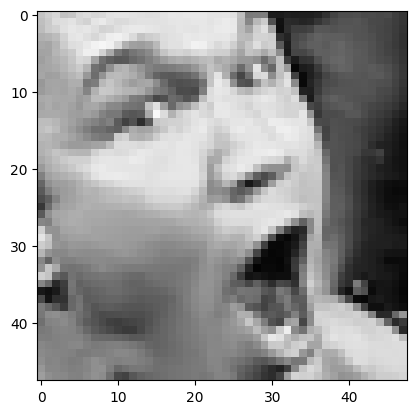

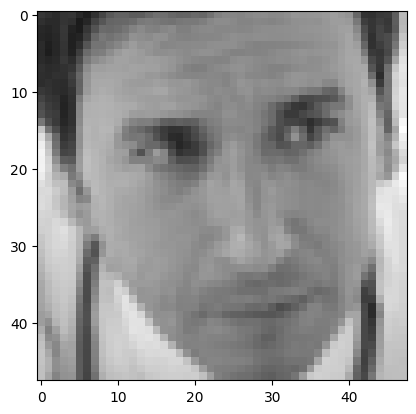

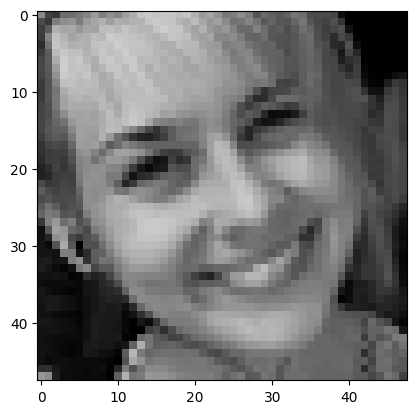

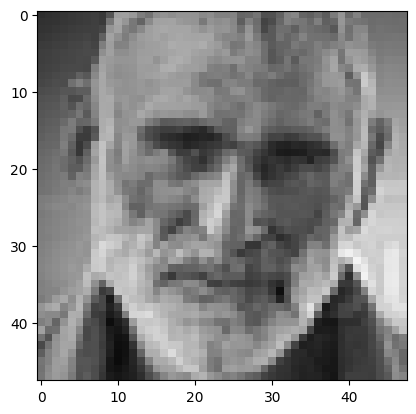

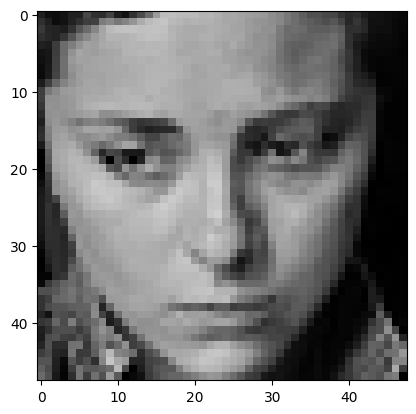

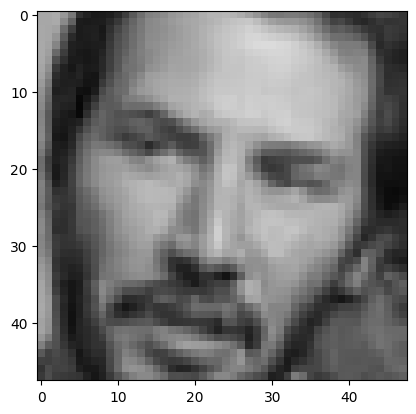

In [15]:
# loading data
x_train = []
y_train = []
x_test = []
y_test = []

cnt = 0
for temp in ["angry", "fearful", "happy", "neutral", "sad", "surprised"]:
    if temp == "angry":
        label = 0
    elif temp == "fearful":
        label = 1
    elif temp == "happy":
        label = 2
    elif temp == "neutral":
        label = 3
    elif temp == "sad":
        label = 4
    elif temp == "surprised":
        label = 5
    #elif temp == "disgusted":
        #label = 6

    path = "/content/train/{}/".format(temp)
    images = glob.glob(path + "*.png")
    images.sort()
    for x in images:
       image = cv2.imread(x)
       image = image / 255
       image = trans.resize(image,(height,weight))
       y_train.append(label)
       x_train.append(image)

    path = "/content/test/{}/".format(temp)
    images = glob.glob(path + "*.png")
    images.sort()
    for x in images:
       image = cv2.imread(x)
       image = image / 255
       image = trans.resize(image,(height,weight))
       y_test.append(label)
       x_test.append(image)
    if cnt <= numClasses:
      plt.figure()
      plt.imshow(image)
    cnt += 1

# preparing data
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.reshape(x_train, (len(x_train), height, weight, 3))
x_test = np.reshape(x_test, (len(x_test), height, weight, 3))
y_train= to_categorical(y_train, num_classes=numClasses)
y_test = to_categorical(y_test, num_classes=numClasses)

def model2(input_shape, num_classes):
  model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  # Freeze the pre-trained layers to avoid overfitting
  for layer in model.layers:
      layer.trainable = False

  # Add custom classification head on top of VGG
  x = Flatten()(model.output)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(num_classes, activation='softmax')(x)

  new_model = Model(inputs=model.input, outputs=predictions)
  new_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

  return new_model

model = model2((height,weight,3), numClasses)
history = model.fit(x_train, y_train,
                    epochs=40,
                    verbose=1,
                    batch_size=64,
                    validation_data=(x_test, y_test))

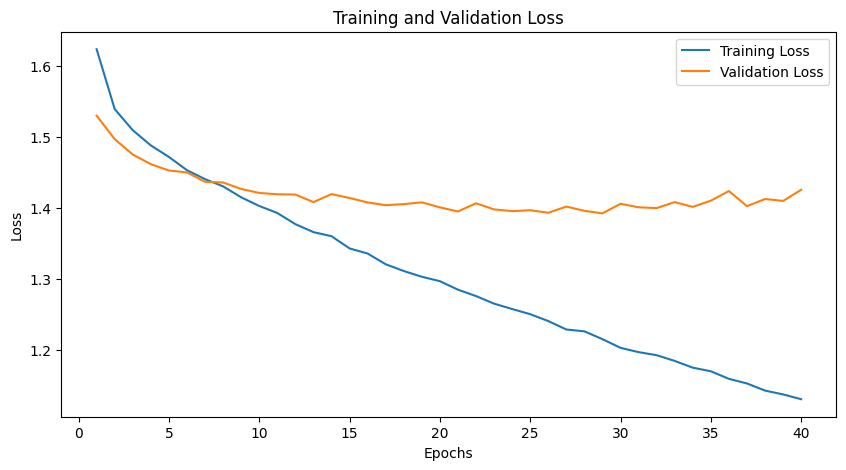

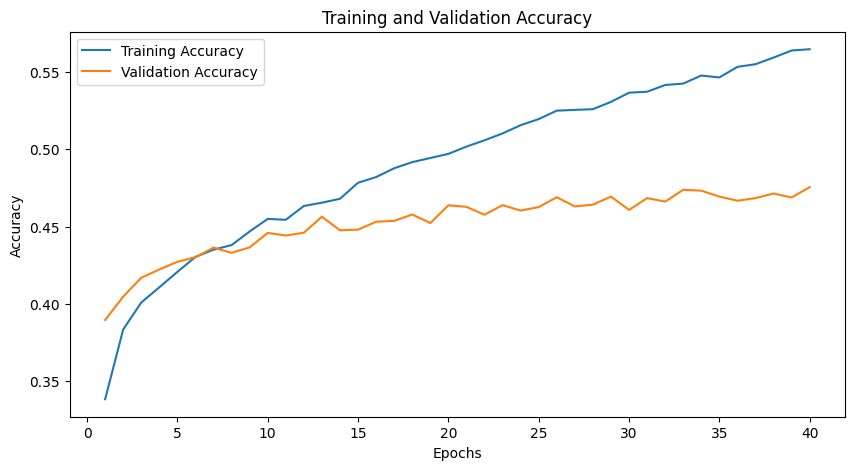

In [16]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
model_json = model.to_json()
with open("model_arch.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

# Evaluate the model on test set
score = model.evaluate(x_test,
                       y_test,
                       verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])

Saved model to disk

 Test accuracy: 0.6611008644104004


Real time with webcam

In [ ]:
model = model_from_json(open("model_arch.json", "r").read())
model.load_weights('model.h5')

In [ ]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
cap=cv2.VideoCapture(0)

while cap.isOpened():
    res,frame=cap.read()

    height, width , channel = frame.shape
    sub_img = frame[0:int(height/6),0:int(width)]

    black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0
    res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.8
    FONT_THICKNESS = 2
    lable_color = (10, 10, 255)
    lable = "Emotion Detection"
    lable_dimension = cv2.getTextSize(lable,FONT ,FONT_SCALE,FONT_THICKNESS)[0]
    textX = int((res.shape[1] - lable_dimension[0]) / 2)
    textY = int((res.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(res, lable, (textX,textY), FONT, FONT_SCALE, (0,0,0), FONT_THICKNESS)
    gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image)
    try:
        for (x,y, w, h) in faces:
            cv2.rectangle(frame, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  2)
            roi_gray = gray_image[y-5:y+h+5,x-5:x+w+5]
            roi_gray=cv2.resize(roi_gray,(48,48))
            image_pixels = img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]
            cv2.putText(res, "Sentiment: {}".format(emotion_prediction), (0,textY+22+5), FONT,0.7, lable_color,2)
            lable_violation = 'Confidence: {}'.format(str(np.round(np.max(predictions[0])*100,1))+ "%")
            violation_text_dimension = cv2.getTextSize(lable_violation,FONT,FONT_SCALE,FONT_THICKNESS )[0]
            violation_x_axis = int(res.shape[1]- violation_text_dimension[0])
            cv2.putText(res, lable_violation, (violation_x_axis,textY+22+5), FONT,0.7, lable_color,2)
    except :
        pass
    frame[0:int(height/6),0:int(width)] =res
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>